In [30]:
import pandas as pd
import numpy as np
import scipy
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline

In [39]:
pan_viability_file = 'data/Pancreatic/Table S4 Tiriac et al CD 2018.xlsx'
pan_viability_targeted_df = pd.read_excel(pan_viability_file, sheet_name = 'Targeted', skiprows = [0], index_col = 0).replace({'#N/A': np.nan})
pan_viability_chemo_df = pd.read_excel(pan_viability_file, sheet_name = 'Chemo', skiprows = [0], index_col = 0).replace({'#N/A': np.nan}).drop(columns = 'Insensitive')
pan_viability_df = pan_viability_targeted_df.join(pan_viability_chemo_df, how = 'outer')
pan_viability_df = pan_viability_df.dropna(how = 'all', axis = 1)
pan_viability_zscore_df = (pan_viability_df - pan_viability_df.mean()) / pan_viability_df.std()
drugs = pan_viability_df.columns
pan_viability_df.head()

,Selumetinib,Afatinib,Bortezomib,Lapatinib,Sunitinib,Olaparib,Nutlin-3,MK-2206,KU-55933,Everolimus,...,LY2874455,SF1670,K-ras(G12C) Inhibitor 9,WIKI4,Disulfuram,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
Sample ID,,,,,,,,,,,,,,,,,,,,,
hF2,0.728,0.772,0.250,0.750,0.740,0.716,0.800,0.756,0.812,0.830,...,0.654,0.734,0.824,0.698,0.538,0.554358,0.712962,0.499950,0.782922,0.887246
hF23,0.692,0.548,0.232,0.762,0.814,0.856,0.928,0.752,0.876,0.728,...,0.630,0.776,0.850,0.838,0.516,0.523995,0.486711,0.547860,0.781999,0.820843
hF24,0.758,0.632,0.238,0.862,0.916,0.854,0.910,0.780,0.842,0.636,...,0.678,0.854,0.830,0.858,0.578,0.609942,0.742389,0.549167,0.671272,0.809528
hF27,0.816,0.828,0.274,0.816,0.780,0.854,0.872,0.798,0.786,0.764,...,0.722,0.696,0.818,0.798,0.572,0.677162,0.636766,0.567865,0.838669,0.852603
hF28,0.700,0.668,0.236,0.842,0.844,0.838,0.856,0.768,0.866,0.750,...,0.570,0.766,0.826,0.818,0.470,0.685010,0.662779,0.651442,0.861745,0.829213


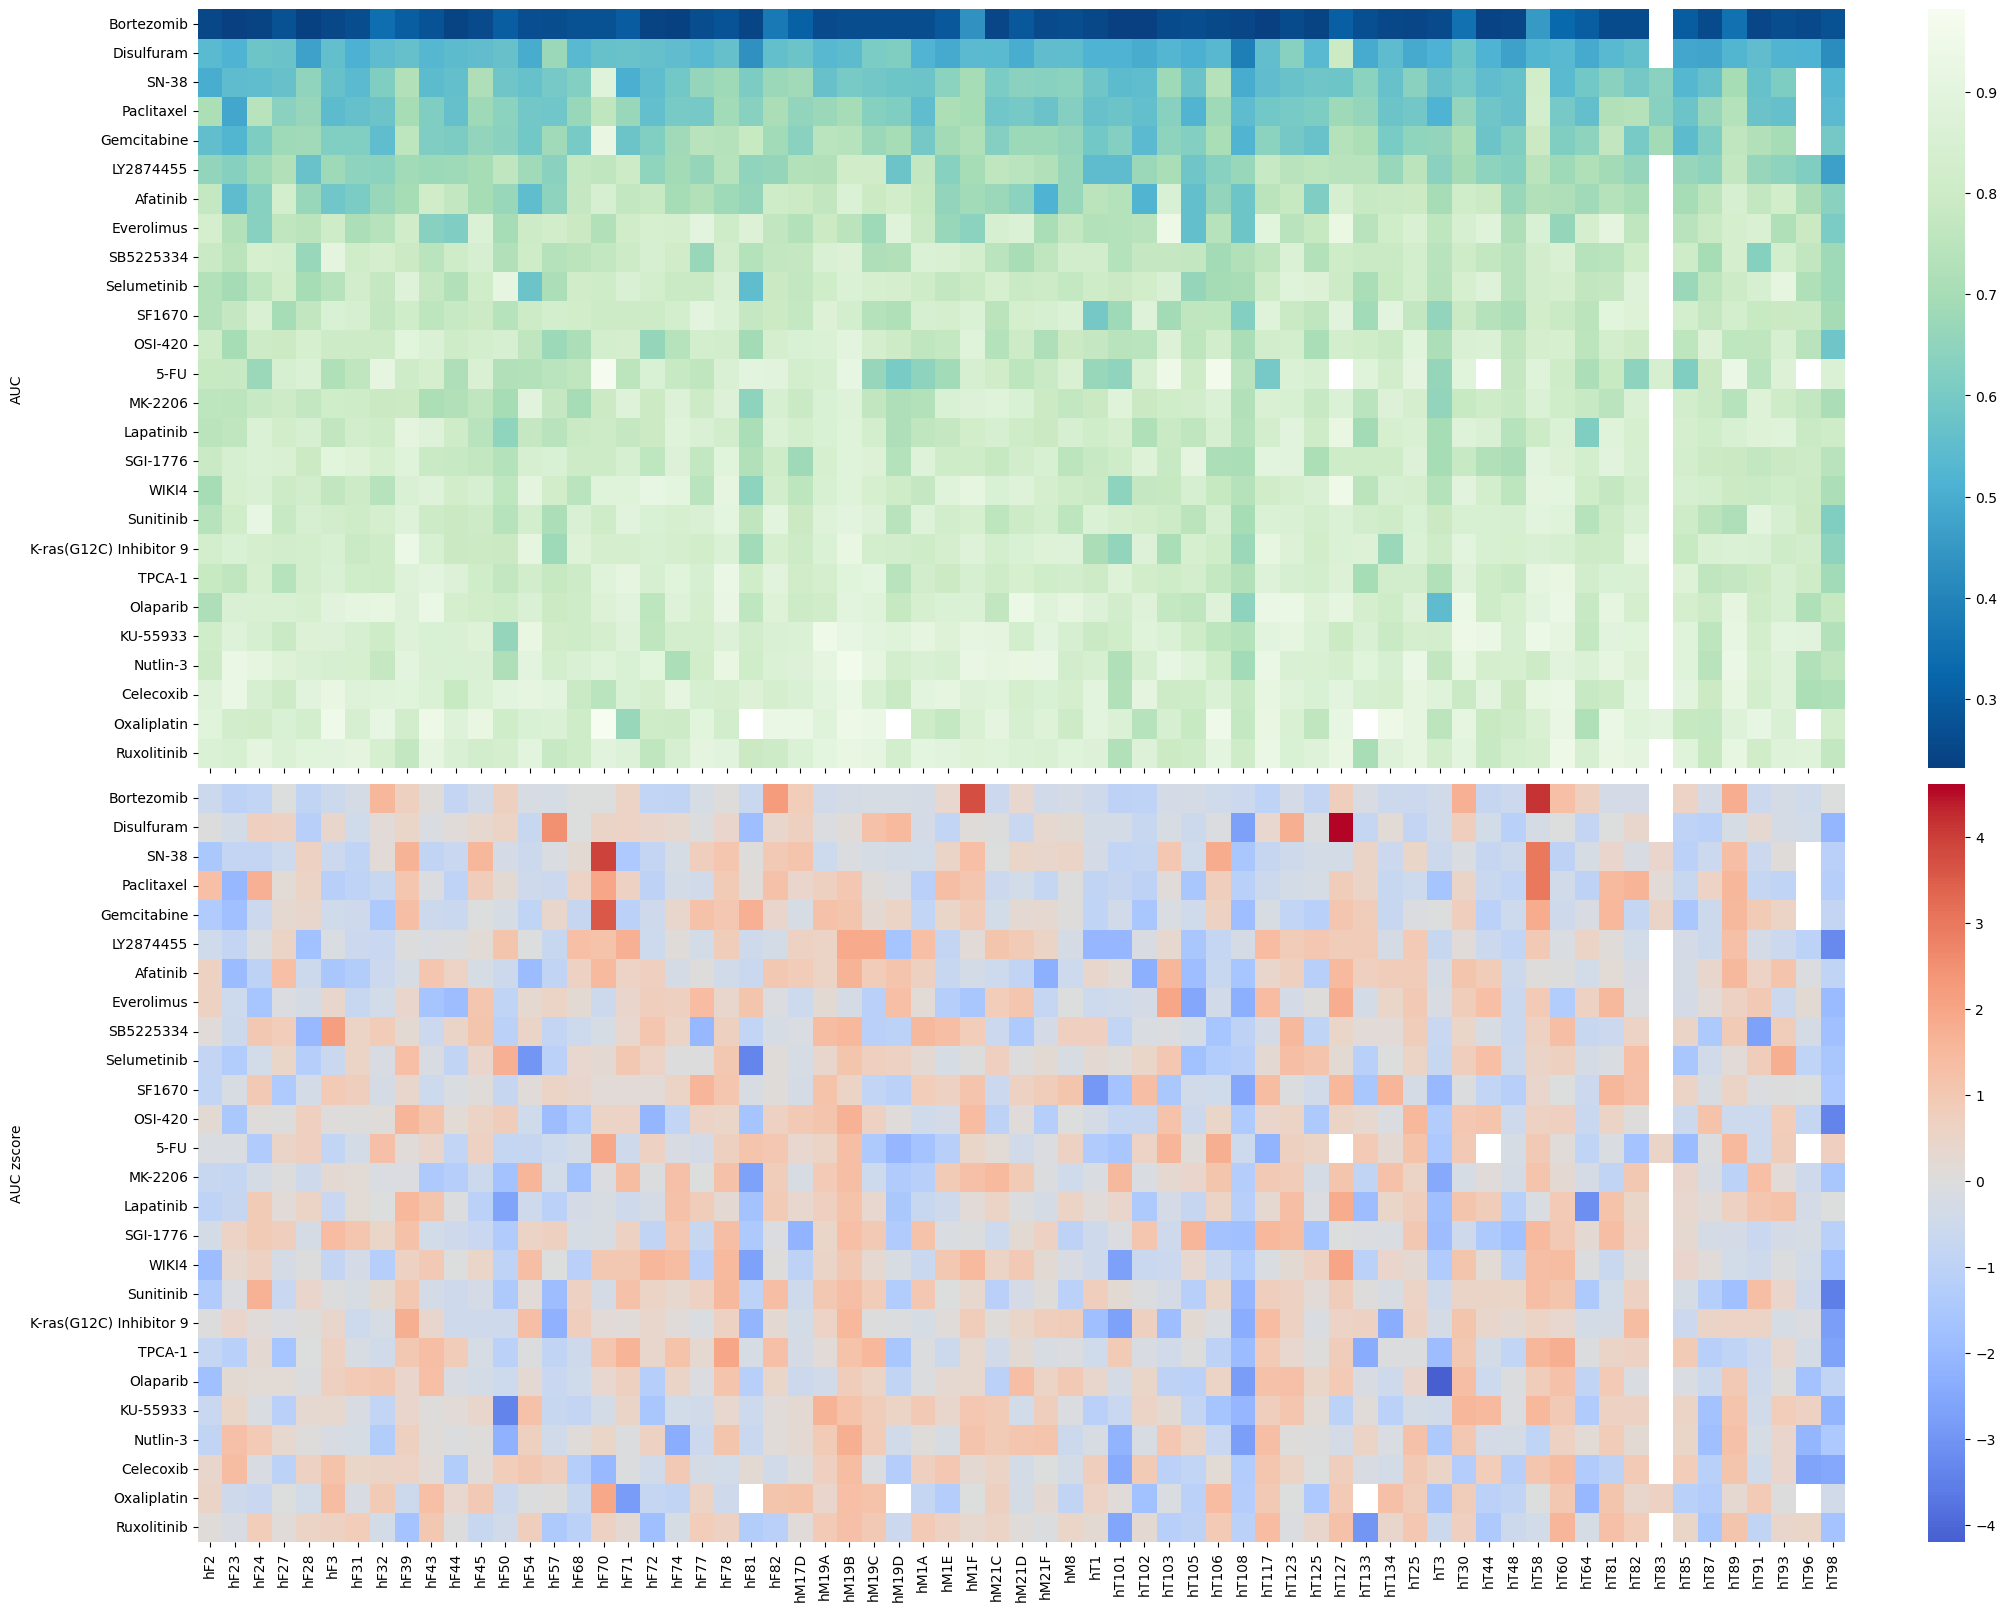

In [4]:
viability_with_mean = pan_viability_df.T
viability_with_mean['mean'] = pan_viability_df.mean()
sorted_drugs = viability_with_mean.sort_values(by = "mean").index.tolist()

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,16), constrained_layout=True, sharex=True)

#sns.set(rc={'figure.figsize':(20, 8)}, font_scale=1)
auc = sns.heatmap(pan_viability_df[sorted_drugs].T, cbar=True, cmap='GnBu_r', ax=axs[0])
auc.set(xlabel=None, ylabel='AUC')

auc_z = sns.heatmap(pan_viability_zscore_df[sorted_drugs].T, cbar=True, cmap='coolwarm', ax=axs[1], center=0)
auc_z.set(xlabel=None, ylabel='AUC zscore')

plt.savefig('figures/data_viz/Pancreatic_drug_response.pdf', 
            facecolor = 'white', transparent = False, dpi=300, bbox_inches = "tight") 

In [15]:
# MODIFY TO GENERATE TWO IMAGES FOR AUC OR AUC ZSCORE`

def set_img_parameters(measure = 'AUC'):
    if measure == 'AUC':
        viability = pan_viability_df
        hmap_file = 'figures/data_viz/Pancreatic_AUC_top3_heatmap.pdf'
        ranking_file = 'figures/data_viz/Pancreatic_AUC_top3_ranking.pdf'
        cmap = 'GnBu_r'
        center = None
        figheight = 3
    elif measure == 'AUC_zscore':
        viability = pan_viability_zscore_df
        hmap_file = 'figures/data_viz/Pancreatic_AUC_zscore_top3_heatmap.pdf'
        ranking_file = 'figures/data_viz/Pancreatic_AUC_zscore_top3_ranking.pdf'
        cmap = 'coolwarm'
        center = 0
        figheight = 7

    return (viability, hmap_file, ranking_file, cmap, center, figheight)

In [33]:
sns.set_style('white')
 
def plot_save_heatmap(measure = 'AUC'):
    (viability, hmap_file, ranking_file, cmap, center, figheight) = set_img_parameters(measure = measure)
    
    chemo_drugs = ['Gemcitabine', 'Paclitaxel', 'SN-38', '5-FU', 'Oxaliplatin']
    target_drugs = list(set(drugs) - set(chemo_drugs))
    
    therapy_suggestion_df = pd.DataFrame(columns = ['patient', 'drug', 'viability', 'chemo'])
    
    counter = 0
    for patient, row in viability.iterrows():    
        drug_suggestions = row.sort_values()
        for (drug, value) in drug_suggestions[:3].items():
            therapy_suggestion_df.loc[counter] = [patient, drug, value, drug in chemo_drugs]
            counter += 1
    therapy_suggestion_df = therapy_suggestion_df.pivot(columns = 'patient', index = 'drug', values = 'viability')
    suggested_drugs = therapy_suggestion_df.index.tolist()
    suggested_chemo = list(set(suggested_drugs) & set(chemo_drugs))
    suggested_targeted = list(set(suggested_drugs) - set(chemo_drugs))
    
    suggested_chemo = (1-therapy_suggestion_df.loc[suggested_chemo]).T.sum().sort_values(ascending=False).index.tolist()
    suggested_targeted = (1-therapy_suggestion_df.loc[suggested_targeted]).T.sum().sort_values(ascending=False).index.tolist()
    
    therapy_suggestion_df = therapy_suggestion_df.loc[suggested_chemo + suggested_targeted]
    
    colors = ['darkorange', 'tan']
    row_colors = [colors[0]] * len(suggested_chemo) + [colors[1]] * len(suggested_targeted)
    cm = sns.clustermap(therapy_suggestion_df, cmap=cmap, cbar_kws={"label": 'AUC', #"ticks":[0.25,0.5,0.7],
                                                                         'orientation': 'horizontal'}, 
                   figsize=(23,figheight), row_cluster=False, col_cluster=False, row_colors=row_colors,
                  cbar_pos=(0.05, 0.9, 0.04, .04), 
                    dendrogram_ratio=(.1, 0), colors_ratio = 0.01, center = center)
    ax = cm.ax_heatmap
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.tick_params(axis='both', which='both', length=0)
    
    reformatted_patients = [p[:2]+'\n'+p[2:] for p in therapy_suggestion_df.columns]
    #ax.set_xticklabels(reformatted_patients, rotation=0)
    ax.set_xticklabels("")
    
    
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=colors[0]), Patch(facecolor=colors[1])]
    plt.legend(handles, ['chemo', 'targeted'], title='Drugs',
                   bbox_to_anchor=(0.04, 0.5), bbox_transform=plt.gcf().transFigure, loc='center left')
    
    plt.savefig(hmap_file, 
        facecolor = 'white', transparent = False, dpi=300, bbox_inches = "tight") 
    return therapy_suggestion_df

In [36]:
def plot_save_top_drugs(therapy_suggestion_df, measure = 'AUC'):
    (viability, hmap_file, ranking_file, cmap, center, figheight) = set_img_parameters(measure = measure)

    drug_palette = sns.color_palette(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', 
                                 '#984ea3', '#999999', '#e41a1c', '#dede00', '#008080', 
                                 '#800080', '#7f00ff', '#4e4e4e', '#ffd8b1', '#e6beff', 
                                 '#fabebe', '#ffdcdc', '#808000', '#b3de69', '#fccde5', 
                                 '#bc80bd', '#ffed6f', '#c6dbef', '#fb8072', '#80b1d3', 
                                 '#bebada'])
    color_mapping = dict(zip(sorted(drugs), sns.color_palette(drug_palette, len(drugs))))
    
    
    therapy_rank_df = pd.DataFrame(np.zeros((len(therapy_suggestion_df), 3)), index = therapy_suggestion_df.index, 
                                                                   columns = ['3rd lowest\nAUC zscore',  
                                                                              '2nd lowest\nAUC zscore',
                                                                                  '1st lowest\nAUC zscore',])
    
    for p in therapy_suggestion_df.columns:
        p_row = therapy_suggestion_df[p].sort_values()
        therapy_rank_df.loc[p_row.index[0]]['1st lowest\nAUC zscore'] += 1
        therapy_rank_df.loc[p_row.index[1]]['2nd lowest\nAUC zscore'] += 1
        therapy_rank_df.loc[p_row.index[2]]['3rd lowest\nAUC zscore'] += 1
    
    sorted_drugs = therapy_rank_df.T.sum().sort_values(ascending=False).index.tolist()
    therapy_rank_df = (therapy_rank_df.loc[sorted_drugs] / therapy_suggestion_df.shape[1]) * 100
    
    sns.set_style('whitegrid')
    ax = therapy_rank_df.T.plot(kind='barh', 
                                color=therapy_rank_df.T.columns.map(color_mapping),
                                stacked=True, figsize=(4,2))
    ax.grid(False)
    ax.set_xlabel('Percentage of organoids')
    ax.set_ylabel(None)
    alph_sorted_colors = sorted(sorted_drugs)
    legend_patches = [mpatches.Patch(color=color_mapping[label], label=label) for label in alph_sorted_colors]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1, 1.055), ncol=1)
    
    plt.savefig(ranking_file, 
                facecolor = 'white', transparent = False, dpi=300, bbox_inches = "tight") 

# Fig. 2 A and B

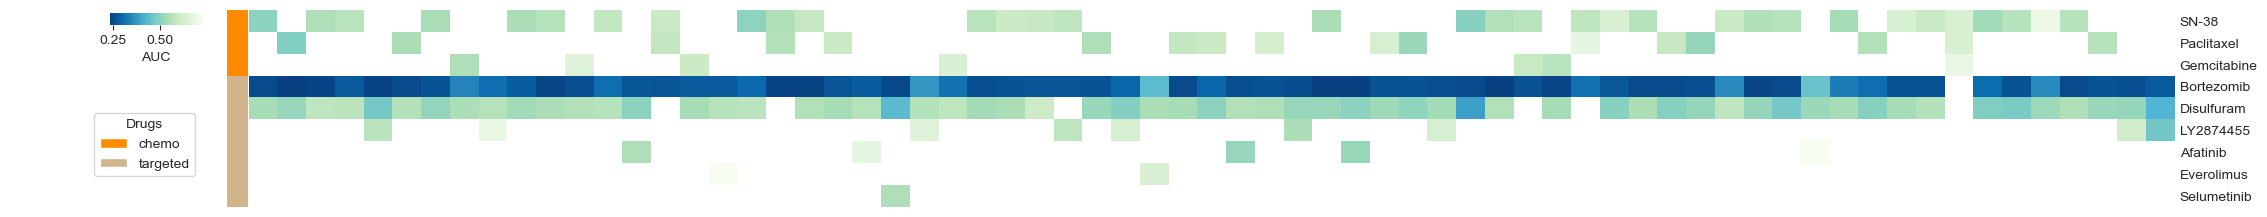

In [26]:
therapy_suggestion_df = plot_save_heatmap(measure = 'AUC')

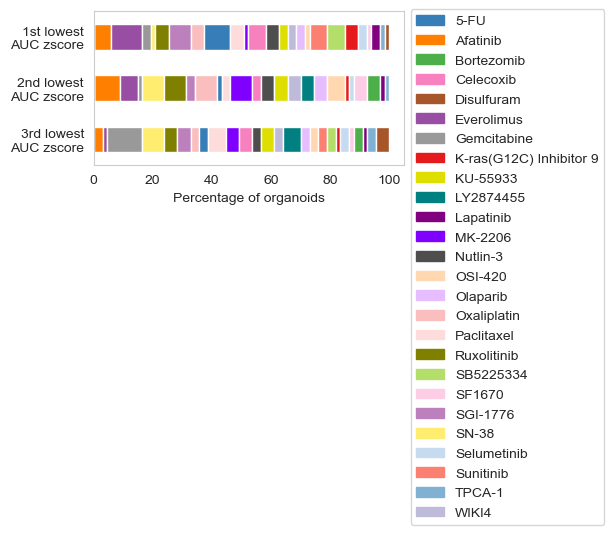

In [37]:
plot_save_top_drugs(therapy_suggestion_df, measure = 'AUC')

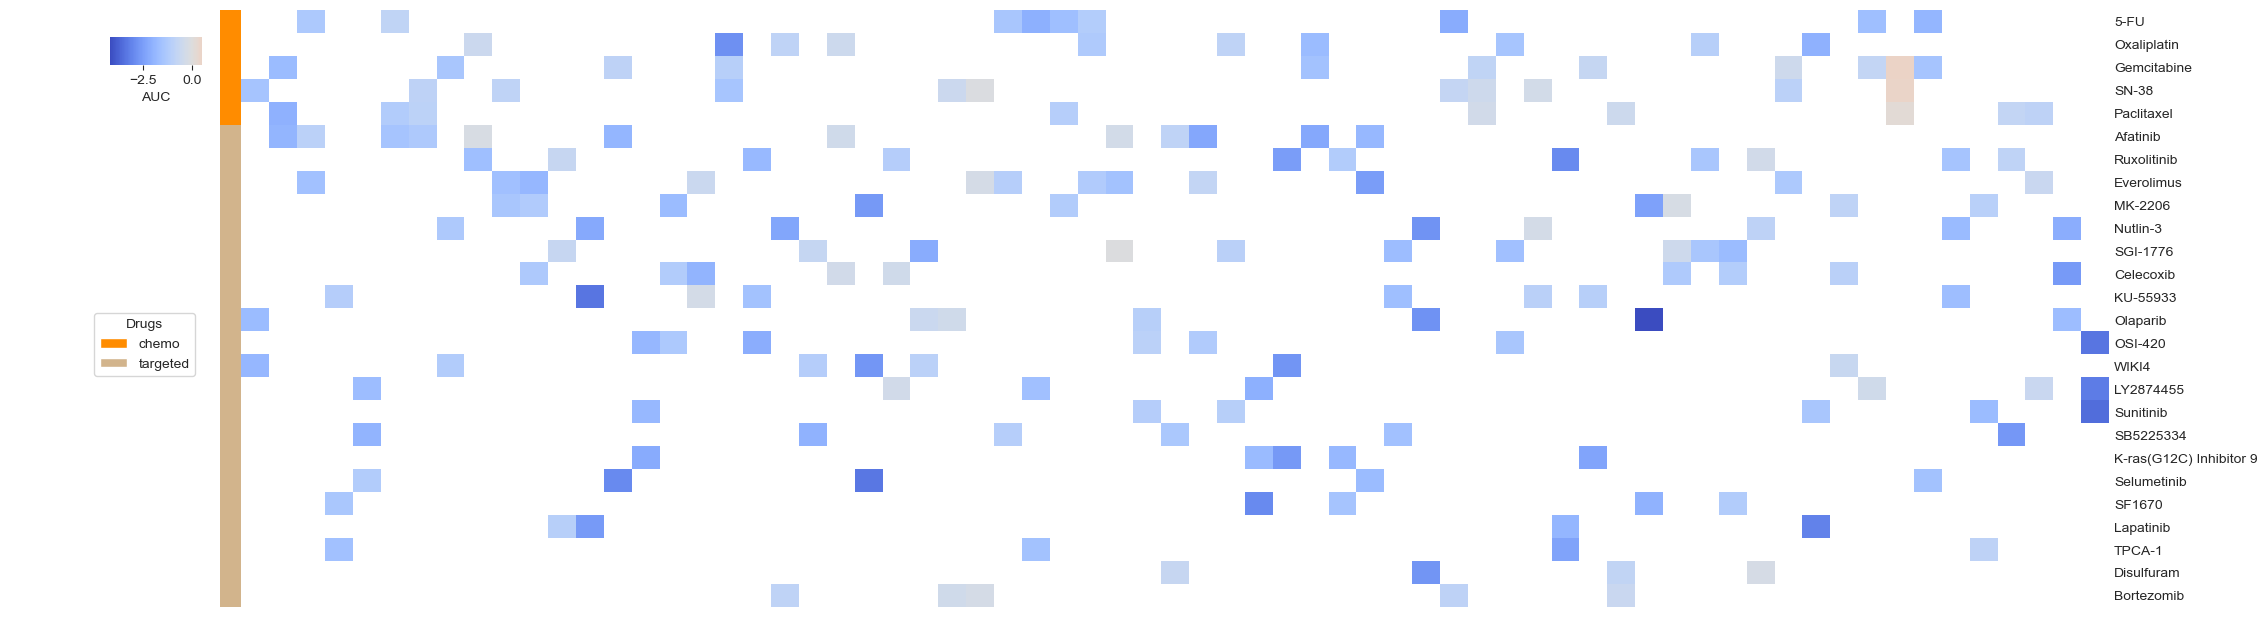

In [34]:
therapy_suggestion_df = plot_save_heatmap(measure = 'AUC_zscore')

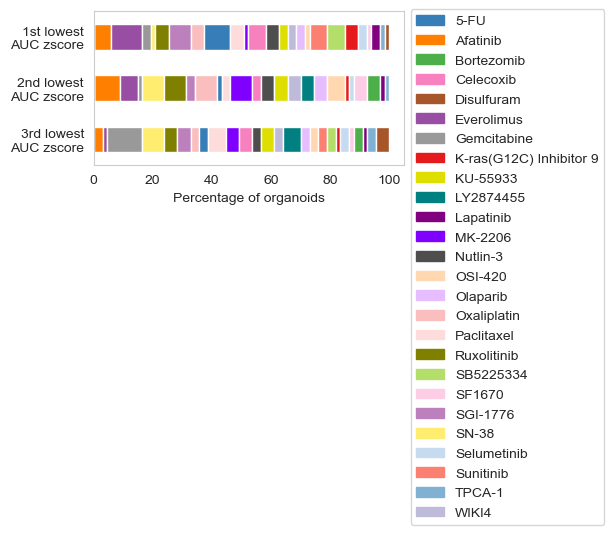

In [38]:
plot_save_top_drugs(therapy_suggestion_df, measure = 'AUC_zscore')